# Class-conditional Experiment on EEG Dataset

This notebook provides a usage guide for generating multi-class time series using Diffusion-TS via [Classifier Guidance](https://arxiv.org/abs/2105.05233). The used [EEG data](https://archive.ics.uci.edu/ml/datasets/EEG+Eye+State) and [pre-processing code](https://github.com/aliseyfi75/COSCI-GAN/blob/main/Code/EEG_data_preprocessing.ipynb) are forked from [COSCI-GAN](https://github.com/aliseyfi75/COSCI-GAN), so their contributions are appreciated here 😊. Also note that this part is not in the original paper, and we use the Transformer Encoder as the underlying model to build the classifier $p(y|x_t, t)$.

In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname('__file__'), '../'))

import torch
import numpy as np

from engine.solver import Trainer
from Utils.metric_utils import visualization
from Data.build_dataloader import build_dataloader
from Utils.io_utils import load_yaml_config, instantiate_from_config
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one, cond_fn
from Models.interpretable_diffusion.ADClassifier import Model

/home/ASR/.conda/envs/EEG/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Args_Example:
    def __init__(self) -> None:
        self.config_path = '../Config/eegADFormer.yaml'
        self.gpu = 0
        self.save_dir = '../class_exp'
        os.makedirs(self.save_dir, exist_ok=True)

args =  Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

dl_info = build_dataloader(configs, args)
model = instantiate_from_config(configs['model']).to(device)
classifier = instantiate_from_config(configs['classifier']).to(device)
#model = torch.load("./Saved/Gen.pth",weights_only=False)
#classifier = torch.load("./Saved/Class.pth",weights_only=False)


trainer = Trainer(config=configs, args=args, model=model, dataloader=dl_info)

torch.Size([1, 529, 64])


In [3]:
trainer.train()
GenSavePath = "./Saved/Gen.pth"
torch.save(model,GenSavePath)

loss: 2.827672:   1%|          | 143/12000 [00:14<20:43,  9.54it/s] 


KeyboardInterrupt: 

In [ ]:
import argparse

parser = argparse.ArgumentParser(description='TimesNet')
parser.add_argument('--task_name', type=str, required=True, default='classification',
                        help='task name, options:[long_term_forecast, short_term_forecast, imputation, classification, anomaly_detection]')
parser.add_argument('--seq_len', type=int, default=128, help='input sequence length')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in encoder')
parser.add_argument('--enc_in', type=int, default=19, help='encoder input size')
parser.add_argument('--top_k', type=int, default=5, help='for TimesBlock')
parser.add_argument('--num_kernels', type=int, default=6, help='for Inception')
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=7, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.1, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--chunk_size', type=int, default=16, help='chunk_size used in LightTS')
parser.add_argument('--patch_len', type=int, default=16, help='patch_len used in PatchTST')
parser.add_argument('--stride', type=int, default=8, help='stride used in PatchTST')
parser.add_argument('--sampling_rate', type=int, default=256, help='frequency sampling rate')
parser.add_argument("--patch_len_list", type=str, default="1,2,4,8", help="a list of patch len used in ADformer")
parser.add_argument("--up_dim_list", type=str, default="19,38,76,152",
                    help="a list of upsampling dimension used in ADformer")
parser.add_argument("--augmentations", type=str, default="none",
                    help="a comma-seperated list of augmentation types (none, jitter or scale). "
                         "Append numbers to specify the strength of the augmentation, e.g., jitter0.1",)
parser.add_argument("--no_inter_attn", action="store_true",
                    help="whether to use inter-attention in encoder, "
                         "using this argument means not using inter-attention", default=False)
parser.add_argument("--no_temporal_block", action="store_true",
                    help="whether to use temporal block in encoder", default=False)
parser.add_argument("--no_channel_block", action="store_true",
                        help="whether to use channel block in encoder", default=False)
parser.add_argument("--num_class", type=int, default=2)

args = parser.parse_args(["--task_name","classification"])

#classifier = Model(args).to(device)

In [ ]:
trainer.train_classfier(classifier)
ClassSavePath = "./Saved/Class.pth"

torch.save(classifier,ClassSavePath)

loss: 0.361035: 100%|██████████| 3000/3000 [25:46<00:00,  1.94it/s]

training complete


In [ ]:
dataset = dl_info['dataset']
seq_length, feature_dim = dataset.window, dataset.var_num

model_kwargs = {}
model_kwargs['classifier'] = classifier
model_kwargs['classifier_scale'] = 0.1

seq_length, feature_dim

(128, 19)

In [ ]:
ori_data_0 = dataset.normalize(dataset.data_0)
origDataSave = "./Saved/origNorm0_EEG.npy";
fakeDataSave = "./Saved/fakeNorm0_EEG.npy";
np.save(origDataSave,ori_data_0)

fake_data_0 = []


model_kwargs['y'] = torch.zeros((100, )).long().to(device)
fake_data = trainer.sample(num=1000, size_every=100, shape=[seq_length, feature_dim], 
                         model_kwargs=model_kwargs, cond_fn=cond_fn)
fake_data_0.append(fake_data)

fake_data_0 = np.concat(fake_data_0)
np.save(fakeDataSave,fake_data_0)
if dataset.auto_norm:
    ori_data_0 = unnormalize_to_zero_to_one(ori_data_0)
    fake_data_0 = unnormalize_to_zero_to_one(fake_data_0)

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step: 100%|██████████| 100/100 [00:20<00:00,  4.80it/s]


In [ ]:
fake_data_0.shape,ori_data_0.shape

((1100, 128, 19), (360, 128, 19))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 720 samples in 0.000s...
[t-SNE] Computed neighbors for 720 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 720 / 720
[t-SNE] Mean sigma: 0.266506
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.693459
[t-SNE] KL divergence after 300 iterations: 1.326211


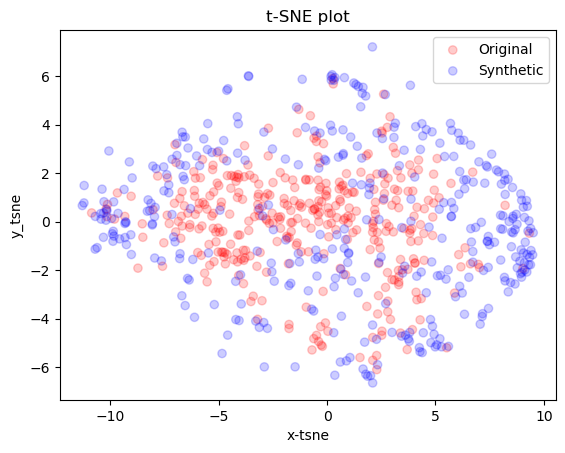

In [ ]:
visualization(ori_data=ori_data_0, generated_data=fake_data_0, analysis='tsne', compare=360)

In [ ]:
ori_data_1 = dataset.normalize(dataset.data_1)
origDataSave = "./Saved/origNorm1_EEG.npy";
fakeDataSave = "./Saved/fakeNorm1_EEG.npy";
np.save(origDataSave,ori_data_1)
model_kwargs['y'] = torch.ones((100, )).long().to(device)

fake_data_1 = trainer.sample(1000, size_every=100, shape=[seq_length, feature_dim], 
                             model_kwargs=model_kwargs, cond_fn=cond_fn)
np.save(fakeDataSave,fake_data_1)
if dataset.auto_norm:
    ori_data_1 = unnormalize_to_zero_to_one(ori_data_1)
    fake_data_1 = unnormalize_to_zero_to_one(fake_data_1)

sampling loop time step: 100%|██████████| 100/100 [00:20<00:00,  4.81it/s]


In [ ]:
ori_data_1.shape,fake_data_1.shape

((408, 128, 19), (1100, 128, 19))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 816 samples in 0.000s...
[t-SNE] Computed neighbors for 816 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 816 / 816
[t-SNE] Mean sigma: 0.098778
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.052963
[t-SNE] KL divergence after 300 iterations: 1.968654


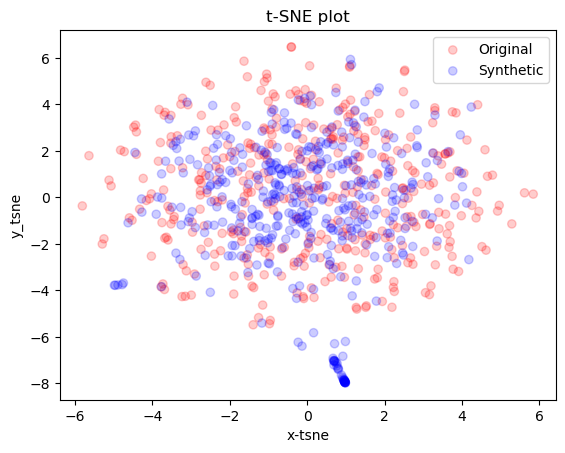

In [ ]:
visualization(ori_data=ori_data_1, generated_data=fake_data_1, analysis='tsne', compare=ori_data_1.shape[0])